# <div align='center' id="top"> Augmentation for percise age prediction task  </div>

## `Table of contents`

- ###  <a href="#split">Train-Test Split</a>
- ###  <a href="#data_vis">Visualization</a>
- ###  <a href="#aug">Augmentation</a>

### <div align='center' id="split">Train-Test Split</div>



<div align = "right"><a href="#top" > Back to top </a></div>

- 80% Train 
- 20% Test (will be split into 10% testing and 10% validation upod data extraction before training)

In [ ]:
import os
import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Source and destination
src_root = "age_data"
dst_root = "age_split"

# Create output structure
for age in os.listdir(src_root):
    age_path = os.path.join(src_root, age)
    if not os.path.isdir(age_path):
        continue

    files = [f for f in os.listdir(age_path) if f.endswith(".jpg")]
    random.shuffle(files)

    split_idx = int(0.8 * len(files))
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # Create train/test directories
    train_dst = os.path.join(dst_root, "train", age)
    test_dst = os.path.join(dst_root, "test", age)
    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(test_dst, exist_ok=True)

    # Copy files
    for f in train_files:
        shutil.copy2(os.path.join(age_path, f), os.path.join(train_dst, f))
    for f in test_files:
        shutil.copy2(os.path.join(age_path, f), os.path.join(test_dst, f))

print("Precise age data split completed (80% train / 20% test)")


Precise age data split completed (80% train / 20% test)


### <div align='center' id="data_vis">Visualization</div>



<div align = "right"><a href="#top" > Back to top </a></div>

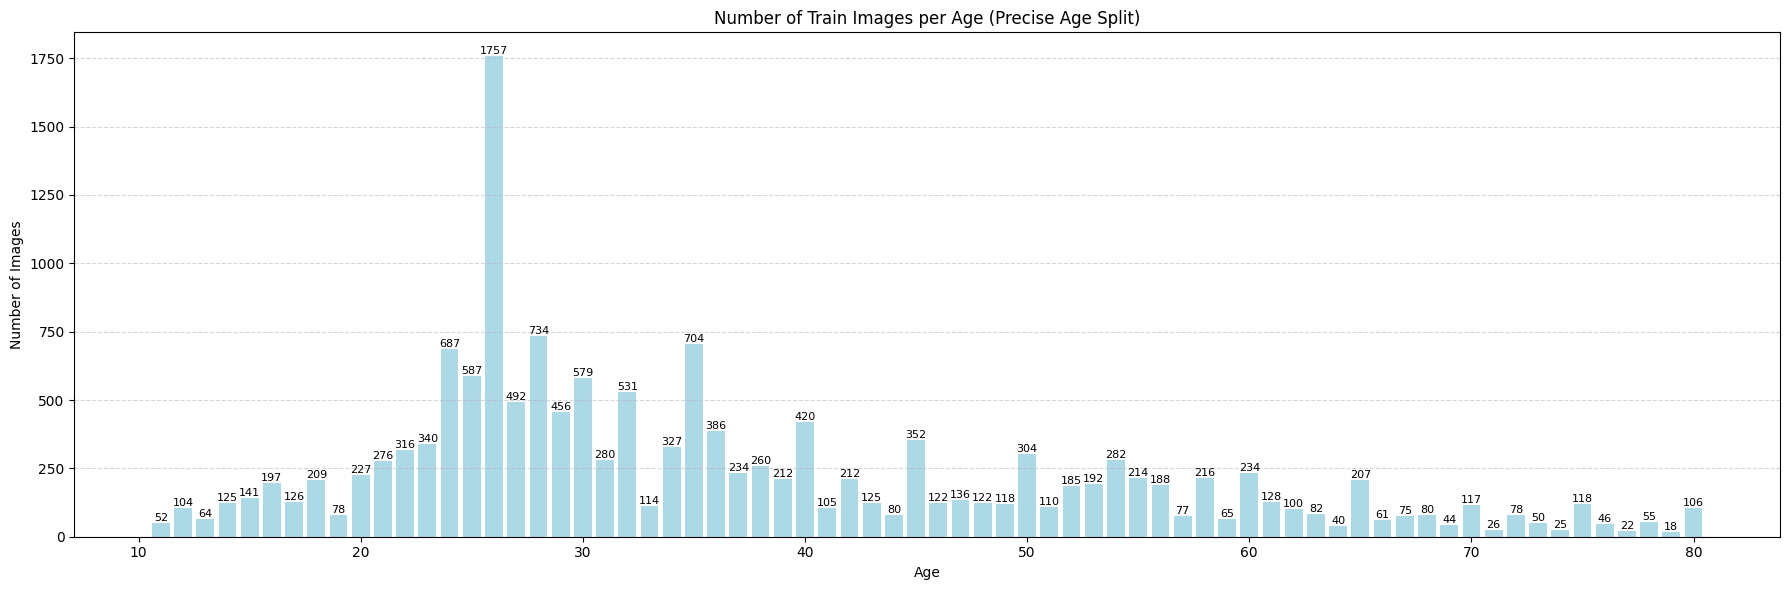

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to training data
train_path = "age_split/train"

# Count images per age
age_counts = defaultdict(int)
for age_folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, age_folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        age_counts[int(age_folder)] = count

# Sort ages
ages = sorted(age_counts.keys())
counts = [age_counts[age] for age in ages]

# Plot
plt.figure(figsize=(18, 6))
bars = plt.bar(ages, counts, color='lightblue')
plt.xlabel("Age")
plt.ylabel("Number of Images")
plt.title("Number of Train Images per Age (Precise Age Split)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add counts on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### <div align='center' id="aug">Augmentation</div>



<div align = "right"><a href="#top" > Back to top </a></div>

Augmentation techniques are:
- Image FLipping 
- 10 degrees left rotation 
- 10 degrees rigths rotation
- apply brightness manipulation with factor 1.25

`age 26 won't be augmented as it's already has many subjects , for the rest of ages , a max of 1500 images will be applied post augmentation to keep data balanced`

Augmenting Bands: 100%|██████████| 70/70 [02:45<00:00,  2.36s/it]


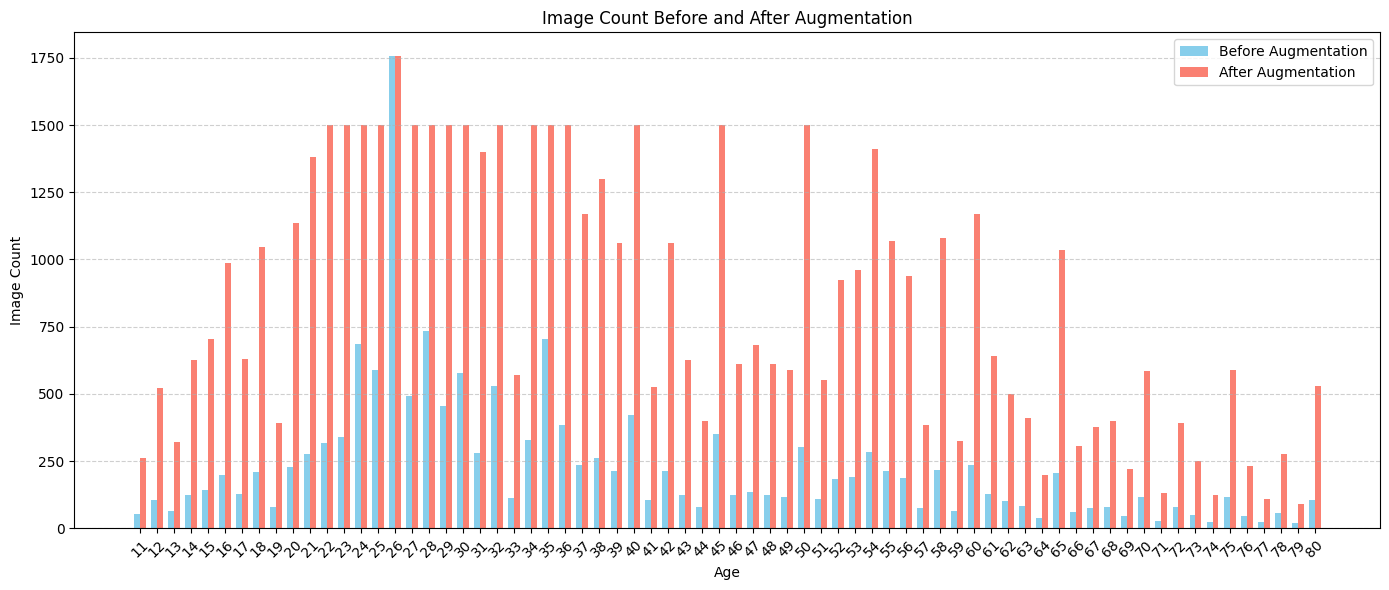

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# ----- Parameters -----
train_dir = "age_split/train"
MAX_IMAGES_PER_BAND = 1500  
AUGMENTATIONS_PER_IMAGE = 4  # flip + brighten + rot_left + rot_right

# Augmentation functions
def flip(img):
    return cv2.flip(img, 1)

def brighten(img, factor=1.25):
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def rotate(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

# Count original images
pre_aug_counts = {}
for band in os.listdir(train_dir):
    band_path = os.path.join(train_dir, band)
    if not os.path.isdir(band_path):
        continue
    pre_aug_counts[band] = len([f for f in os.listdir(band_path) if f.endswith(".jpg")])

# Perform augmentation
for band, count in tqdm(pre_aug_counts.items(), desc="Augmenting Bands"):
    if band == "26":  # skip age 26 only
        continue

    band_path = os.path.join(train_dir, band)
    filenames = [f for f in os.listdir(band_path) if f.endswith(".jpg")]
    augmented = 0
    i = 0

    while len(os.listdir(band_path)) < MAX_IMAGES_PER_BAND and i < len(filenames):
        fname = filenames[i]
        img_path = os.path.join(band_path, fname)
        img = cv2.imread(img_path)
        if img is None:
            i += 1
            continue
        base_name = fname.rsplit(".", 1)[0]

        for suffix, aug_fn in zip(
            ["_flip", "_bright", "_rot10", "_rot-10"],
            [flip, brighten, lambda x: rotate(x, 10), lambda x: rotate(x, -10)]
        ):
            if len(os.listdir(band_path)) >= MAX_IMAGES_PER_BAND:
                break
            aug_img = aug_fn(img)
            save_path = os.path.join(band_path, f"{base_name}{suffix}.jpg")
            cv2.imwrite(save_path, aug_img)
            augmented += 1
        i += 1

# Count post-augmentation images
post_aug_counts = {}
for band in os.listdir(train_dir):
    band_path = os.path.join(train_dir, band)
    if not os.path.isdir(band_path):
        continue
    post_aug_counts[band] = len([f for f in os.listdir(band_path) if f.endswith(".jpg")])

# ----- Plot before vs after -----
bands = sorted(pre_aug_counts.keys(), key=lambda x: int(x.split("-")[0]) if "-" in x else int(x))

x = np.arange(len(bands))
pre_vals = [pre_aug_counts[band] for band in bands]
post_vals = [post_aug_counts.get(band, 0) for band in bands]

plt.figure(figsize=(14, 6))
width = 0.35

plt.bar(x - width/2, pre_vals, width=width, label="Before Augmentation", color="skyblue")
plt.bar(x + width/2, post_vals, width=width, label="After Augmentation", color="salmon")

plt.xticks(x, bands, rotation=45)
plt.xlabel("Age")
plt.ylabel("Image Count")
plt.title("Image Count Before and After Augmentation")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


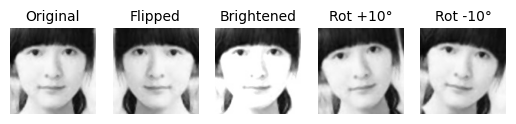

In [ ]:
import random

def show_augmented_examples(train_dir, num_examples=1):
    bands = [b for b in os.listdir(train_dir) if b != "26"]
    selected_examples = []

    for _ in range(num_examples):
        band = random.choice(bands)
        band_path = os.path.join(train_dir, band)
        originals = [f for f in os.listdir(band_path) if f.endswith(".jpg") and
                     not any(s in f for s in ["_flip", "_bright", "_rot10", "_rot-10"])]
        if not originals:
            continue
        original = random.choice(originals)
        base_name = original.rsplit(".", 1)[0]
        paths = [os.path.join(band_path, f"{base_name}{suffix}.jpg") for suffix in ["", "_flip", "_bright", "_rot10", "_rot-10"]]
        selected_examples.append(paths)

        for j, img_path in enumerate(paths):
            if not os.path.exists(img_path):
                print(f"Missing image: {img_path}")
                continue
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, j + 1)
            title = ["Original", "Flipped", "Brightened", "Rot +10°", "Rot -10°"][j]
            plt.imshow(img)
            plt.title(title, fontsize=10)
            plt.axis('off')


show_augmented_examples("age_split/train")
